In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random

# Load the dataset from the uploaded file
file_path = 'healthcare-dataset-stroke-data.csv'
df = pd.read_csv(file_path)

# Data Preprocessing
# Handle missing values
for column in df.select_dtypes(include=[np.number]).columns:
    df[column].fillna(df[column].mean(), inplace=True)
for column in df.select_dtypes(include=[object]).columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

# Convert categorical columns to numeric
df = pd.get_dummies(df, drop_first=True)

# Separate features and target
X = df.drop("stroke", axis=1)
y = df["stroke"]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the Isolation Tree class
class IsolationTree:
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, current_depth=0):
        if current_depth >= self.max_depth or len(X) <= 1:
            return None

        # Randomly select a feature
        feature_idx = random.randint(0, X.shape[1] - 1)
        feature_values = X[:, feature_idx]

        # Randomly select a split value
        split_value = random.uniform(np.min(feature_values), np.max(feature_values))

        # Split the data
        left_split = X[X[:, feature_idx] < split_value]
        right_split = X[X[:, feature_idx] >= split_value]

        left_tree = self.fit(left_split, current_depth + 1)
        right_tree = self.fit(right_split, current_depth + 1)

        self.tree = (feature_idx, split_value, left_tree, right_tree)
        return self.tree

    def path_length(self, x, current_depth=0):
        if self.tree is None:
            return current_depth

        feature_idx, split_value, left_tree, right_tree = self.tree
        if x[feature_idx] < split_value:
            if left_tree is None:
                return current_depth + 1
            return self.path_length_from_tree(left_tree, x, current_depth + 1)
        else:
            if right_tree is None:
                return current_depth + 1
            return self.path_length_from_tree(right_tree, x, current_depth + 1)

    def path_length_from_tree(self, tree, x, current_depth):
        if tree is None:
            return current_depth

        feature_idx, split_value, left_tree, right_tree = tree
        if x[feature_idx] < split_value:
            if left_tree is None:
                return current_depth + 1
            return self.path_length_from_tree(left_tree, x, current_depth + 1)
        else:
            if right_tree is None:
                return current_depth + 1
            return self.path_length_from_tree(right_tree, x, current_depth + 1)

# Define the Isolation Forest class
class IsolationForestCustom:
    def __init__(self, n_trees=100, sample_size=256):
        self.n_trees = n_trees
        self.sample_size = sample_size
        self.forest = []

    def fit(self, X):
        self.forest = []
        max_depth = int(np.log2(self.sample_size))
        for _ in range(self.n_trees):
            sample_indices = np.random.choice(X.shape[0], self.sample_size, replace=False)
            sample = X[sample_indices]
            tree = IsolationTree(max_depth)
            tree.fit(sample)
            self.forest.append(tree)

    def path_length(self, x):
        return np.mean([tree.path_length(x) for tree in self.forest])

    def anomaly_score(self, X):
        scores = []
        for x in X:
            avg_path_length = self.path_length(x)
            score = 2 ** (-avg_path_length / c(self.sample_size))
            scores.append(score)
        return scores

def c(n):
    return 2 * (np.log(n - 1) + 0.5772156649) - 2 * (n - 1) / n

# Training
iso_forest_custom = IsolationForestCustom(n_trees=100, sample_size=256)
iso_forest_custom.fit(X_train)

# Get the anomaly scores
scores = iso_forest_custom.anomaly_score(X_test)
print(scores)

[0.5855640107817249, 0.5827972755524916, 0.5851679601817475, 0.5907371275731237, 0.5835864346885462, 0.5907371275731237, 0.5927389349342992, 0.5847721774535569, 0.586356916322361, 0.586356916322361, 0.5827972755524916, 0.5820091835628013, 0.5831917216369561, 0.5855640107817249, 0.5963592979098824, 0.5871508955273356, 0.5820091835628013, 0.5827972755524916, 0.5855640107817249, 0.5820091835628013, 0.5824030962545877, 0.5820091835628013, 0.5824030962545877, 0.5831917216369561, 0.5820091835628013, 0.5824030962545877, 0.5820091835628013, 0.5820091835628013, 0.5939432739351083, 0.5824030962545877, 0.5827972755524916, 0.5891405503669019, 0.5843766624159757, 0.5839814148879495, 0.5831917216369561, 0.5871508955273356, 0.5827972755524916, 0.5915370379721369, 0.5824030962545877, 0.5824030962545877, 0.5835864346885462, 0.5859603294347885, 0.5824030962545877, 0.5907371275731237, 0.5824030962545877, 0.5835864346885462, 0.5824030962545877, 0.595552866573678, 0.5851679601817475, 0.5851679601817475, 0.

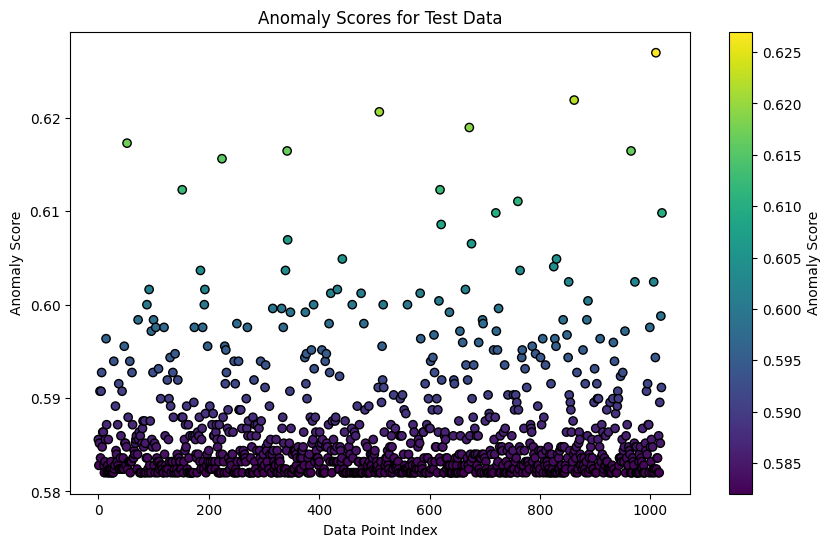

In [7]:
import matplotlib.pyplot as plt

# anomaly scores
anomaly_scores = iso_forest_custom.anomaly_score(X_test)

# ScatterPlot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(anomaly_scores)), anomaly_scores, c=anomaly_scores, cmap='viridis', edgecolors='k')
plt.colorbar(label='Anomaly Score')
plt.title('Anomaly Scores for Test Data')
plt.xlabel('Data Point Index')
plt.ylabel('Anomaly Score')
plt.show()


IsolationTree(max_depth):
    if current_depth >= max_depth or len(X) <= 1:
        return {"size": len(X)}

    feature_idx = randomly select feature index
    split_value = randomly select split value within feature range
    partition data into left and right based on split_value

    left_tree = recursively build tree on left partition
    right_tree = recursively build tree on right partition

    return {
        "feature_idx": feature_idx,
        "split_value": split_value,
        "left": left_tree,
        "right": right_tree
    }

IsolationForest(n_trees, sample_size, max_depth):
    for each tree in n_trees:
        sample_indices = randomly select sample_size indices
        sample = X[sample_indices]
        build IsolationTree with max_depth on sample
        store tree in forest

    anomaly_score(X):
        for each data point in X:
            calculate average path length across all trees
            calculate anomaly score based on average path length
        return anomaly scores


Purpose:

Isolation Forest: Detects anomalies by isolating them with fewer partitions, focusing on instances that are different from the majority.
Random Forest: Used for supervised learning tasks like classification or regression by averaging predictions from an ensemble of decision trees.

Construction:

Isolation Forest: Randomly selects a single feature for splitting at each node, aiming to isolate anomalies efficiently.
Random Forest: Randomly selects a subset of features for each tree (feature bagging) and splits nodes based on the best feature and split point determined by information gain or impurity reduction.

Final Forecast:

Isolation Forest: Computes anomaly scores based on the average path length across trees. Anomalies have shorter path lengths.
Random Forest: Aggregates predictions from multiple trees to make a final prediction. The final forecast is typically determined by averaging (for regression) or voting (for classification).

Summary:

Isolation Forests and Random Forests differ fundamentally in their objectives and construction methodologies. While Random Forests are versatile for supervised learning tasks, Isolation Forests excel in detecting anomalies or outliers efficiently by isolating them based on their distinctive features and partitioning behavior. These differences in approach make each algorithm suitable for distinct problem domains and applications within machine learning.